# Kinematics Time Series Example

## Imports

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt # Plotting graphs.
import pandas as pd # Data manipulation.
import seaborn as sns; sns.set() # Only used for styling plots.
import numpy as np # Arrays and matrices.
from sklearn import metrics # Scoring our estimators.

print("Imports Finished.")

Imports Finished.


## Velocity Time Series Data Generation

In [2]:
timestep = 0.010 # seconds
time_end = 10.0 # seconds

# Create time columns with time in seconds and in miliseconds.
time_array_s = np.arange(0, time_end, timestep)
time_array_ms = time_array_s * 100

# Assemble into a pandas dataframe.
data = [time_array_s, time_array_ms]
dataT = np.transpose(data)
df = pd.DataFrame(dataT, columns = ["time_s", "time_ms"])

In [3]:
# Create a zeros column (floats).
df["zeros"] = 0.0

# Create some velocity information
use_sine_wave_velocity = False
if use_sine_wave_velocity:
    df["velocity"] = np.sin(df["time_s"]) * 10.0 # Sine Wave (max v error = -0.1)
else:
    df["velocity"] = df["time_s"] # Simple linear (max v error = 0.01)

# Step-wise velocity.
df["velocity_stepwise"] = np.round_(df["velocity"], decimals=1, out=None) # Nearest 0.1

# Simple Moving Average of the step-wise velocity.
df["velocity_step_smooth"] = df["velocity_stepwise"].rolling(window=10, center=True, win_type="triang").mean()

## Calculations

In [4]:
# Calculate acceleration as the change in velocity.
df["velocity_previous"] = df["velocity"]
df["velocity_previous"] = df["velocity_previous"].shift(periods=1, fill_value=0)
df["velocity_delta"] = df["velocity"] - df["velocity_previous"]
df["accel_groundtruth"] = df["velocity_delta"] / timestep

# Delete intermediate columns.
df = df.drop(columns=["velocity_previous", "velocity_delta"]) # Not necessary?

# Calculate accel again, this time using the step-wise velocity.
df["velocity_previous"] = df["velocity_step_smooth"]
df["velocity_previous"] = df["velocity_previous"].shift(periods=1, fill_value=0)
df["velocity_delta"] = df["velocity_step_smooth"] - df["velocity_previous"]
df["accel_step_smooth"] = df["velocity_delta"] / timestep

# Delete intermediate columns.
df = df.drop(columns=["velocity_previous", "velocity_delta"]) # Keep 

# Simple Moving Average of the derived acceleration.
df["accel_SMA_100"] = df["accel_step_smooth"].rolling(window=100, center=True, win_type="triang").mean()

# Calculate position as the integral of velocity.
df["position"] = df["velocity"] * timestep
df["position"] = df["position"].cumsum() # Cumulative Sum

## Plotting

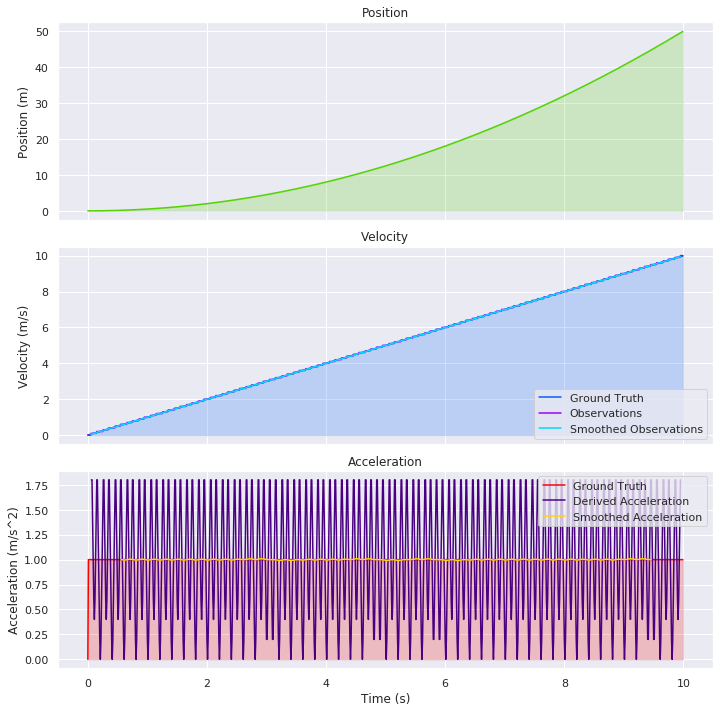

In [5]:
# Select x-axis limits.
use_x_axis_limits = False
use_y_axis_limits = False

if use_x_axis_limits:
    s1 = 4
    s2 = 5
    
if use_y_axis_limits:
    y1 = 0
    y2 = 2

# Plot the results.
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10,10), sharex=True)

axes[0].set_title("Position")
axes[0].set_ylabel("Position (m)")
axes[0].plot(df["time_s"], df["position"], color="#53d304")
axes[0].fill_between(df["time_s"], df["position"], df["zeros"], alpha=0.2, color="#53d304")

axes[1].set_title("Velocity")
axes[1].set_ylabel("Velocity (m/s)")
axes[1].plot(df["time_s"], df["velocity"], color="#005ff9")
axes[1].fill_between(df["time_s"], df["velocity"], df["zeros"], alpha=0.2, color="#005ff9")
axes[1].plot(df["time_s"], df["velocity_stepwise"], color="#9a00f9")
axes[1].plot(df["time_s"], df["velocity_step_smooth"], color="#00dcf9")
axes[1].legend(["Ground Truth", "Observations", "Smoothed Observations"], loc="lower right")

if use_y_axis_limits:
    axes[1].set_ylim([y1, y2])

axes[2].set_title("Acceleration")
axes[2].set_ylabel("Acceleration (m/s^2)")
axes[2].set_xlabel("Time (s)")
axes[2].plot(df["time_s"], df["accel_groundtruth"], color="#f90202")
axes[2].fill_between(df["time_s"], df["accel_groundtruth"], df["zeros"], alpha=0.2, color="#f90202")
axes[2].plot(df["time_s"], df["accel_step_smooth"], color="indigo")
axes[2].plot(df["time_s"], df["accel_SMA_100"], color="gold")
axes[2].legend(["Ground Truth", "Derived Acceleration", "Smoothed Acceleration"], loc="upper right")

if use_x_axis_limits:
    axes[2].set_xlim([s1, s2])

plt.tight_layout() # Ensures parts of subplots do not overlap.
plt.show()

## Error Testing

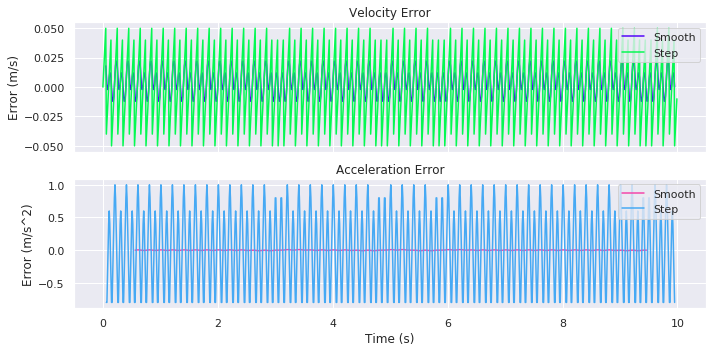

In [6]:
# Measure error
df["velocity_error_step"] = df["velocity"] - df["velocity_stepwise"]
df["velocity_error_smooth"] = df["velocity"] - df["velocity_step_smooth"]

df["accel_error_step"] = df["accel_groundtruth"] - df["accel_step_smooth"]
df["accel_error_smooth"] = df["accel_groundtruth"] - df["accel_SMA_100"]

# Plot the results.
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=True)

axes[0].set_title("Velocity Error")
axes[0].set_ylabel("Error (m/s)")
axes[0].plot(df["time_s"], df["velocity_error_smooth"], color="#5204f9")
axes[0].plot(df["time_s"], df["velocity_error_step"], color="#04f952")
axes[0].legend(["Smooth", "Step"], loc="upper right")

axes[1].set_title("Acceleration Error")
axes[1].set_ylabel("Error (m/s^2)")
axes[1].plot(df["time_s"], df["accel_error_smooth"], color="#f446a9")
axes[1].plot(df["time_s"], df["accel_error_step"], color="#46a9f4")
axes[1].legend(["Smooth", "Step"], loc="upper right")

axes[1].set_xlabel("Time (s)")

#axes[1].set_xlim([2, 4])

plt.tight_layout() # Ensures parts of subplots do not overlap.
plt.show()

In [7]:
mse_velocity_step = df["velocity_error_step"] * df["velocity_error_step"]
mse_velocity_step = mse_velocity_step.mean()

mse_velocity_smooth = df["velocity_error_smooth"] * df["velocity_error_smooth"]
mse_velocity_smooth = mse_velocity_smooth.mean()

max_error_velocity_step = df["velocity_error_step"].abs().max()
max_error_velocity_smooth = df["velocity_error_smooth"].abs().max()

mse_accel_step = df["accel_error_step"] * df["accel_error_step"]
mse_accel_step = mse_accel_step.mean()

mse_accel_smooth = df["accel_error_smooth"] * df["accel_error_smooth"]
mse_accel_smooth = mse_accel_smooth.mean()

max_error_accel_step = df["accel_error_step"].abs().max()
max_error_accel_smooth = df["accel_error_smooth"].abs().max()

metrics = [mse_velocity_step, mse_velocity_smooth, max_error_velocity_step, max_error_velocity_smooth, \
          mse_accel_step, mse_accel_smooth, max_error_accel_step, max_error_accel_smooth]
names = ["mse_velocity_step", "mse_velocity_smooth", " max_error_velocity_step","max_error_velocity_smooth", \
        "mse_accel_step", "mse_accel_smooth", "max_error_accel_step", "max_error_accel_smooth"]
metrics_df = pd.DataFrame(metrics, names)
metrics_df

,0
mse_velocity_step,0.000850
mse_velocity_smooth,0.000129
max_error_velocity_step,0.050000
max_error_velocity_smooth,0.022000
mse_accel_step,0.323354
mse_accel_smooth,0.000013
max_error_accel_step,1.000000
max_error_accel_smooth,0.007920


## Conclusion
When the velocity is given to us by a sensor measurement, it can be limited by sampling rate and sampling resolution. If our ground-truth velocity is a sine-wave, we can introduce artificial sampling rate and sampling resolution error by rounding the velocity to the nearest 0.1 m/s. If our ground-truth velocity is linear, rounding only introduces sampling resolution error, and sampling rate is constant.

By using smoothing functions for velocity and acceleration, it is possible to get lower error (both mean squared error and max absolute error).